# Homework 2 (HW2)

By the end of this homework, we expect you to be able to:

- Preprocess data and make it amenable to statistical analysis and machine learning models;
- Train and test out-of-the-box machine learning models in Python;
- Carry out simple multivariate regression analyses;
- Use techniques to control for covariates;
- Conduct an observational study and reason about its results.

---

## Important Dates

- Homework release: Fri 18 Nov 2022
- **Homework due**: Fri 02 Dec 2022, 23:59
- Grade release: Mon 12 Dec 2022

---

##  Some rules

1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you may do so, but must justify your choice.
2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you don’t change any of the files.)
3. Be sure to provide a textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice.
4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation (**in markdown**).
5. Back up any hypotheses and claims with data, since this is an important aspect of the course.
6. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a single notebook (plus the required data files) in the *master/main* branch. If there are multiple notebooks present, we will **not grade** anything.
7. We will **not run your notebook for you**! Rather, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.
8. In continuation to the previous point, interactive plots, such as those generated using `plotly`, should be **strictly avoided**!
9. Make sure to print results or dataframes that confirm you have properly addressed the task.

---

## Context

Congratulations! You have just been hired as a data scientist at [FC Tokyo, a J1 League Japanese professional football club based in Chōfu, Tokyo](https://en.wikipedia.org/wiki/FC_Tokyo). The company hired you to carry out a variety of data-related tasks, which will be explained in further detail below.

Your manager, Mr. Naoki Ogane, has noticed that an unusually high number of players in your team have birthdays in either April or May, so he asked you to investigate this further -- is this just a coincidence, or are players born in April or May simply better?

## Data

To answer Mr. Ogane's questions, you will use data from Wikipedia biographies. This is a subset of the Pantheon dataset (1). For tasks 1 to 4, you will use the file `japanese_athletes.csv.gz`. For task 5, you will use the file `all_entities.csv.gz`. Both datasets are`.csv` files with the same columns:

- `id`: a unique identifier per individual.
- `name`: name of the individual.
- `occupation`: the occupation of the individual (for `japanese_athletes.csv.gz`, these are all sports-related).
- `gender`: gender of the athlete.
- `alive`: flag indicating if the athlete was alive in 2020 when the dataset was collected.
- `bplace_country`: the country where the athlete was born  (for `japanese_athletes.csv.gz`, the value here is always 'Japan').
- `birthdate`: the date when the athlete was born.
- `birthyear`: the year when the athlete was born.
- `pageviews`: number of pageviews received by the athlete's page across Wikipedia language editions.

(1) Yu, A. Z., et al. (2016). Pantheon 1.0, a manually verified dataset of globally famous biographies. Scientific Data 2:150075. doi: 10.1038/sdata.2015.75

In [1]:
# import used libraries
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import datetime

## Task 1 — 20 pts

As a good data scientist, you first load the data and perform some small sanity checks on it.

**1.1** Load the dataset containing data about Japanese athletes into memory using pandas. First, load the data directly from the compressed file. Then, print the first few lines of the dataset.

**1.2** Find the different occupations in the data and how many individuals belong to each occupation.

**1.3** Calculate the percentage of individuals who remain alive in the data.

**1.4** Plot the distribution of birth years in the dataset. In other words, what fraction of individuals are born each year? (Note that the data contains individuals born only after the year 1900).

**1.5** Plot the empirical cumulative distribution function (CDF) to visualize the distribution of pageviews. Here you should use a linear scale for both the x-axis and the y-axis.

**1.6** **Discuss:** why is it hard to visualize the distribution in the above ECDF plot?

**1.7** Re-do the above CDF plot using a log scale for both the x-axis and the y-axis. Additionally, plot vertical lines that indicate the distribution's arithmetic and geometric means.

**1.8** **Discuss:** Visually, does it look like the distribution is a power law?

**1.9** Estimate the 95% confidence intervals of the geometric mean and the arithmetic mean of pageviews using bootstrap resampling.

**1.10** **Discuss:** What advantages does the geometric mean have over the arithmetic mean to summarize the distribution?

In [2]:
# 1.1
jp_athletes = pd.read_csv('data/japanese_athletes.csv.gz')

# We convert the birthdates from string to python datetime
jp_athletes['birthdate'] = pd.to_datetime(jp_athletes['birthdate'], format="%Y-%m-%d").dt.to_pydatetime()

# Due to inconsistencies between the year in the birthdate column and the year in the birthyear column for several athletes,
# we assume the year in the birthdate column is the correct one
jp_athletes['birthyear'] = jp_athletes['birthdate'].dt.year
jp_athletes.head(5)

,id,name,occupation,gender,alive,bplace_country,birthdate,birthyear,pageviews
0,25864486,Hisataka Okamoto,SOCCER PLAYER,M,True,Japan,1933-12-14,1933,455.0
1,1682054,Kunishige Kamamoto,SOCCER PLAYER,M,True,Japan,1944-04-15,1944,57847.0
2,20639249,Akira Kitaguchi,SOCCER PLAYER,M,True,Japan,1935-03-08,1935,759.0
3,20641463,Tsukasa Hosaka,SOCCER PLAYER,M,False,Japan,1937-03-03,1937,1672.0
4,25864343,Takashi Kasahara,SOCCER PLAYER,M,True,Japan,1918-03-26,1918,541.0


There are 11 different occupations.


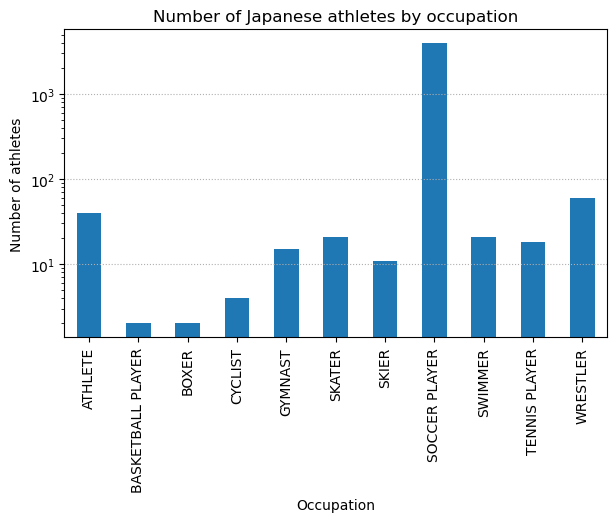

In [3]:
# 1.2
# group by occupation to find the number of occupations
# and the number of athletes per occupation
occups = jp_athletes.groupby('occupation').count()[['id']]
print("There are %s different occupations." %(len(occups)))

# Plot the number of athletes per occupation in a bar graph
occups.plot(kind='bar', figsize=(7,4))
plt.grid(axis='y', ls=':')
plt.title("Number of Japanese athletes by occupation")
plt.legend('', frameon=False)
plt.xlabel("Occupation")
plt.ylabel("Number of athletes")
plt.yscale('log') # the axis is logarithmic, else there are so many soccer players that we cannot see the other values
plt.show()

In [4]:
# 1.3

# Filter the dataset to only keep alive athletes
alive = jp_athletes[jp_athletes['alive']] # == True
alive_percentage=round(100*len(alive)/len(jp_athletes), 2)
# Find the proportion of alive athletes
print(f'{alive_percentage}% of the athletes in the dataset are alive.')

97.19% of the athletes in the dataset are alive.


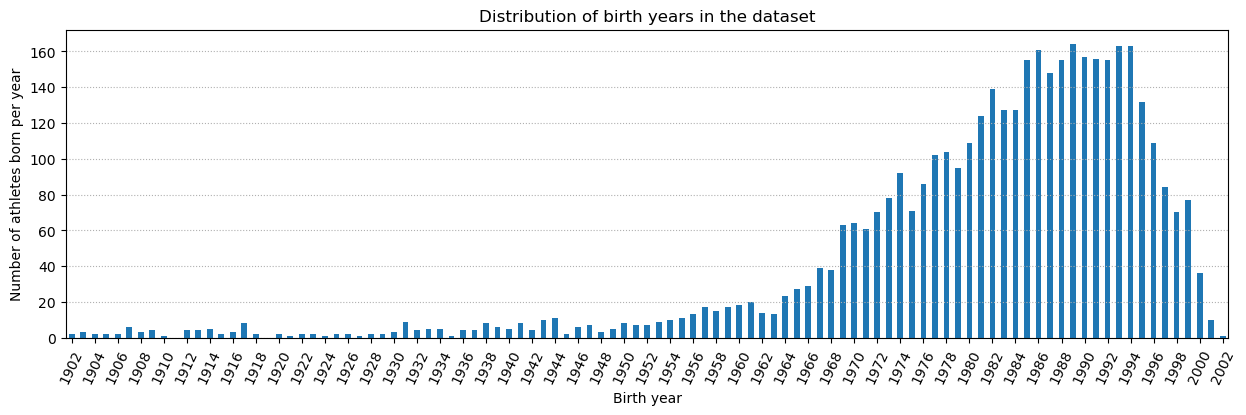

In [5]:
# 1.4
# we group by birth year to find the number of athletes born each year
birth_year_distribution=jp_athletes['birthyear'].value_counts().rename_axis('years').reset_index(name='birth_count').astype(np.int64)

# we add the years where no athletes were born
years=list(range(min(birth_year_distribution['years']), max(birth_year_distribution['years'])+1))
for i in years:
    if i not in list(birth_year_distribution['years']):
        birth_year_distribution.loc[len(birth_year_distribution)] = [i, 0]

# we plot the distribution
birth_year_distribution.sort_values(by='years').plot.bar(x='years' , y='birth_count', figsize = (15,4))
plt.grid(axis='y', ls=':')
plt.title("Distribution of birth years in the dataset")
plt.legend('', frameon=False)
plt.xticks(np.arange(0, 101, step=2), rotation=65)
plt.xlabel("Birth year")
plt.ylabel('Number of athletes born per year')
plt.show() 

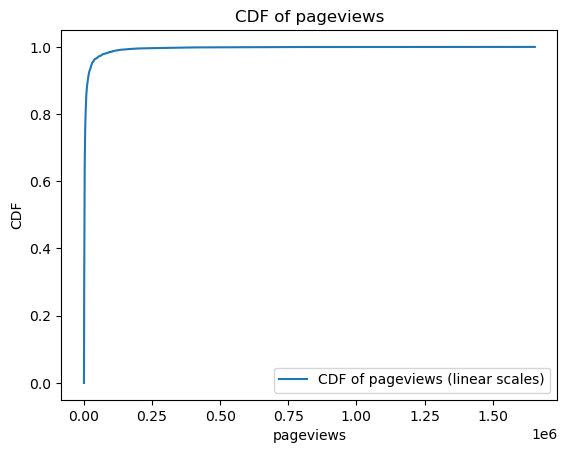

In [6]:
# 1.5 Plot the empirical cumulative distribution function (CDF) to visualize the distribution of pageviews. Here you should use a linear scale for both the x-axis and the y-axis.
jpa_pageviews=pd.DataFrame()
jpa_pageviews['pageviews'] = jp_athletes['pageviews'].astype(int).sort_values(ascending=True)
jpa_pageviews['cdf'] = 1*np.arange(len(jpa_pageviews)) / len(jpa_pageviews-1)

jpa_pageviews

jpa_pageviews.plot(x='pageviews', y='cdf', label="CDF of pageviews (linear scales)")
plt.legend()
plt.ylabel('CDF')
plt.title('CDF of pageviews')
plt.show()

**1.6**

The curve shows a very fast growth towards a cumulative value of 1. This behavior is similar to the one of a heavy-tailed distribution. The linear ECDF representation doesn't allow to clearly show the details of the curve with large gradients. In this context, we cannot differentiate the number of athletes with lower values of pageviews. A log-log scale representation would be better suited for this case. 

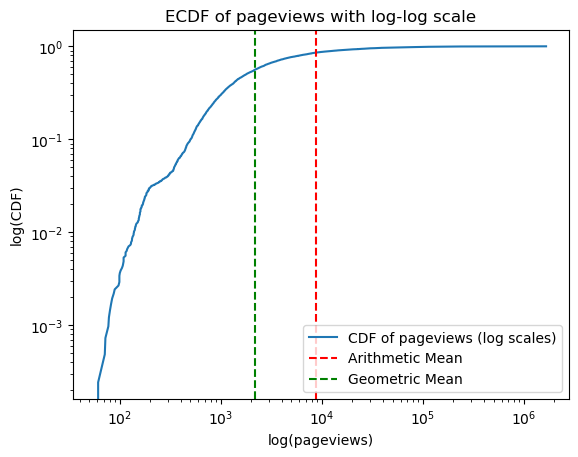

Mean: 8678.479990298327, Geometric mean: 2185.8108347071675


In [7]:
#1.7 
jpa_pageviews.plot(x='pageviews', y='cdf', label="CDF of pageviews (log scales)")
plt.xscale('log')
plt.yscale('log')

mu = jpa_pageviews['pageviews'].mean()
gmu = stats.gmean(jpa_pageviews['pageviews'], axis=0)

plt.axvline(x=mu, color='red', linestyle='--', label='Arithmetic Mean')
plt.axvline(x=gmu, color='green', linestyle='--', label='Geometric Mean')
plt.legend()
plt.title('ECDF of pageviews with log-log scale')
plt.xlabel('log(pageviews)')
plt.ylabel('log(CDF)')
plt.show()

print(f'Mean: {mu}, Geometric mean: {gmu}')

**1.8**
 
It does not look like a power law, because on log-log scale it should be a straight line which is not the case of our curve.

In [8]:
# 1.9
mu_list=[]
gmu_list=[]
nb_draws=1000
for i in range(nb_draws):
    new_sample=jpa_pageviews['pageviews'].sample(n=len(jpa_pageviews), replace=True, random_state=i, axis=0)
    mu_list.append(new_sample.mean())
    gmu_list.append(stats.gmean(new_sample, axis=0))
    
mu_list.sort()
gmu_list.sort()

mu_CI_low=round(mu_list[int(0.025*nb_draws)],4)
mu_CI_high=round(mu_list[int(0.975*nb_draws)],4)
gmu_CI_low=round(gmu_list[int(0.025*nb_draws)],4)
gmu_CI_high=round(gmu_list[int(0.975*nb_draws)],4)

print(f'Mean CI: {mu_CI_low}-{mu_CI_high}')
print(f'Geometric mean CI: {gmu_CI_low}-{gmu_CI_high}')

Mean CI: 7472.8043-10013.9728
Geometric mean CI: 2097.8869-2286.0834


**1.10**

The geometric mean is less affected by extreme values, in fact the fluctuations in the sample do not affect the geometric mean and it gives more weight to small observations.

## Task 2 — 20 pts

Next, investigate the question posed by Mr. Ogane. *Why do so many Tokyo FC players have birthdays in the same month?* 
Here you will not look specifically at Tokyo FC players, but more generally at the birthdays of the athletes in the dataset you have explored in Task 1

**2.1** Calculate and plot the distribution of births (among the athletes contained in the Wikipedia dataset) over months, i.e., what percentage of births happen in January, February, etc.

**2.2** Puzzled with the results, you use census data to retrieve the percentage of births happening each month (this is given to you in an array below). Plot this distribution.

**2.3** **Discuss:** what is different between the distributions you ploted in **2.1** and **2.2**

After discussing with your colleagues at work, a theory comes to your mind: school in Japan starts in April. Children who were born between April 1 and March 31 of the following year are placed within the same grade. Therefore, you suspect that the observed pattern may have something to do with when students start school.

**2.4** Considering that students in Japanese schools have the same birth distribution over the months of the year as the overall Japanese population, i.e., the `birth_per_month` array that was provided to you, calculate:

- For students born in April, how many months older are they than the average student in their grade?
- For students born in March, how many months younger are they than the average student in their grade?

**2.5** **Discuss:** Considering your common sense and the results obtained from the simulation: what advantage do students born in April have over those born in March? How may this affect their odds of becoming professional athletes?

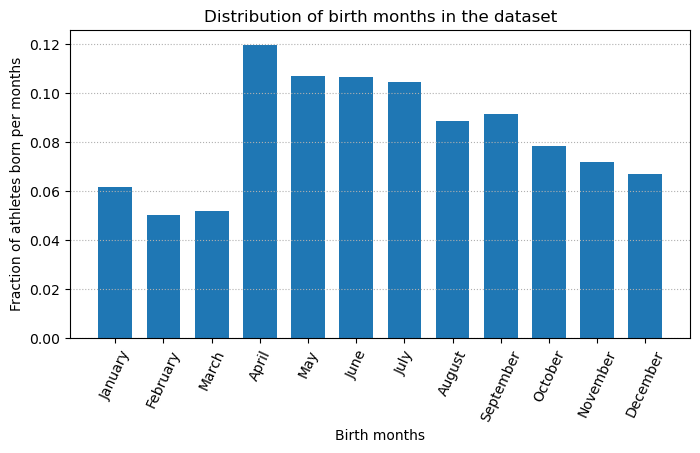

In [9]:
# 2.1

months_list=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
birth_months=pd.DataFrame(index=range(1,13))
birth_months['months']=months_list
birth_months['count']=np.zeros(12)

# Converting the birthdate strings to Datetime objects was done in 1.1

for i in range(len(jp_athletes)):
    birth_months['count'][jp_athletes['birthdate'][i].month]+=1

plt.figure(figsize = (8,4))
plt.bar(birth_months['months'], birth_months['count']/len(jp_athletes), width=0.7)
plt.grid(axis='y', ls=':')
plt.title("Distribution of birth months in the dataset")
plt.legend('', frameon=False)
plt.xticks(rotation=65)
plt.xlabel("Birth months")
plt.ylabel('Fraction of athletes born per months')
plt.show() 


In [10]:
birth_per_month = np.array([
0.08118368,0.08148065, 0.08182577, 0.07982728, 0.08301363,
0.08422556, 0.08518067, 0.08925791, 0.08635247, 0.08460279,
0.08258825, 0.08046134
])

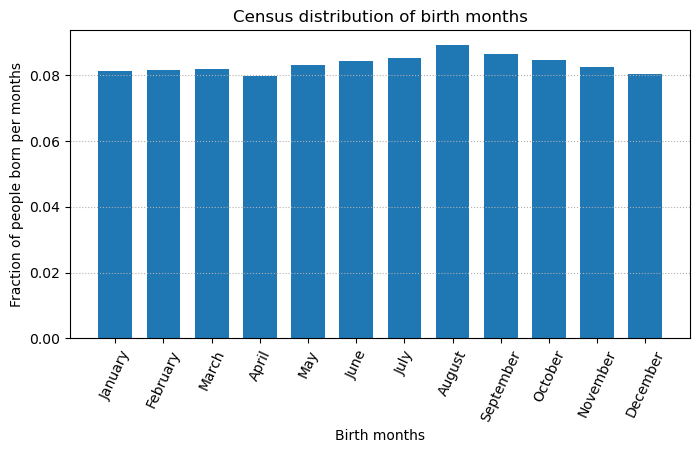

In [11]:
# 2.2
plt.figure(figsize = (8,4))
plt.bar(birth_months['months'], birth_per_month, width=0.7)
plt.grid(axis='y', ls=':')
plt.title("Census distribution of birth months")
plt.legend('', frameon=False)
plt.xticks(rotation=65)
plt.xlabel("Birth months")
plt.ylabel('Fraction of people born per months')
plt.show() 

**2.3**

We can see that in 2.1 the values are not uniformly distributed they are decreasing and in 2.2 we can observe a uniform distribution. In the 2.2 the standard deviation is very smal compared to the plot in 2.1 but they have the same mean.

In [12]:

# 2.4

mean_month=0
for month in range(0,12):
    mean_month += month*birth_per_month[month-9]

print(f'For students born in April, they are {mean_month} months older than the average student in their grade.')  
print(f'For students born in March, they are {11-mean_month} months younger than the average student in their grade.')   

For students born in April, they are 5.4707690499999995 months older than the average student in their grade.
For students born in March, they are 5.5292309500000005 months younger than the average student in their grade.


**2.5**

We note a strong decrease of the proportion of athletes born each month during the japan scholar year. More than 61% of atheletes are born in the first half of the year. There is no proof students born in april are stronger than students born in march, thus the difference of proportion should come from somewhere else.

There could be different reasons to this strong gap :
- If we consider that an athlete has started training at a very young age, maybe the fact that a child 10 months older than another will be phisically stronger is the reason he will be more successfull and encouraged to continue.
- Maybe more selections happen at the start of the scholar year for each grade, thus athletes born early will turn 18 before others and have more chance of being selected for a team.


## Task 3 — 20 pts

You report your findings to Mr. Ogane, who receives them with great interest. He asks you: *is there a causal effect between being older than your peers and becoming a Wikipedia-famous athlete?* (Here, “Wikipedia-famous” refers to those individuals notable enough to have made it into English Wikipedia.)

**3.1** Create a new column in the dataframe called `date_diff` representing the distance between the athlete's birthdate and the cutoff date of his school class. 
- For individuals born in April, May, June, July, August, and September: The distance should be positive and represent the number of days between the birthdate and the previous April 1. For example, if someone is born on April 1, the distance is 0, if someone is born on April 10, the distance is 9, etc.
- For individuals born in October, November, December, January, February, and March: The distance should be negative and represent the number of days between the following April 1 and the birthdate. For example, if someone is born on March 31, the distance is -1; if someone is born on March 27, the distance is -5.
- Print the `date_diff` for the athletes with ids:  `20639249` and `58982155`.

**3.2** Create three numpy arrays `x`, `y`, and `ind` all of size 360. 
- `x` should contain the integers between -180 and 179 (-180 and 179 inclusive). 
- `y` should contain the percentage of athletes born with a `date_diff` equal to the corresponding value of `x`.
- `ind` should contain 0 if `x` is smaller than zero and 1 if `x` is bigger or equal to zero.


**3.3** Estimate the following linear regression: `y ~ x + ind` using `statsmodels`. Report the summary of the model.

**3.4** **Discuss:** What does the coefficient associated with the dummy variable `ind` captures in the above regression?

**3.5** Use the model parameters to estimate the percentage of athletes born on March 31st, i.e., use the intercept ($\beta_0$) and the coefficient associated with `x` ($\beta_1$) and calculate: $\beta_0 - 1 * \beta_1$ (recall that $x$ equals -1 in March 31st).

**3.6** Use the model parameters to estimate the percentage of athletes born on April 1st.

**3.7** **Discuss:** Drawing from your knowledge of observational studies and the questions answered thus far, respond to Mr. Ogane's question: *is there a causal effect between being older than your peers and becoming a Wikipedia-famous athlete?* Explain whether the evidence you have obtained is convincing and why.

---

**Comment**: Note that in **3.2**, the size of the array created is slightly smaller than the number of days in the year. This is for simplicity's sake.

In [13]:
# 3.1

mask_end_year = jp_athletes['birthdate'].dt.month >= 10
birthday_of_year = jp_athletes['birthdate'].dt.day_of_year
april_day_of_year = [pd.to_datetime('04/01/'+str(int(year))).day_of_year for year in jp_athletes.birthyear]
nb_days_in_year = [pd.to_datetime('12/31/'+str(int(year+1))).day_of_year for year in jp_athletes.birthyear]

jp_athletes['date_diff'] = birthday_of_year - april_day_of_year - mask_end_year * (nb_days_in_year)


print(f"The 'date_diff' of the player with id '20639249' is {int(jp_athletes[jp_athletes['id']==20639249]['date_diff'])}.")
print(f"The 'date_diff' of the player with id '58982155' is {int(jp_athletes[jp_athletes['id']==58982155]['date_diff'])}.")


The 'date_diff' of the player with id '20639249' is -24.
The 'date_diff' of the player with id '58982155' is 6.


In [14]:
# 3.2

x=np.arange(-180, 180, 1)
ind = (x>=0)*1
y = [len(jp_athletes[jp_athletes['date_diff']==date_diff]) for date_diff in x]



In [15]:
# 3.3

import statsmodels.formula.api as smf

df = pd.DataFrame()
df['x']=x
df['y']=y
df['ind']=ind

mod = smf.ols(formula='y ~ x + ind', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     118.8
Date:                Fri, 02 Dec 2022   Prob (F-statistic):           2.87e-40
Time:                        23:37:41   Log-Likelihood:                -977.59
No. Observations:                 360   AIC:                             1961.
Df Residuals:                     357   BIC:                             1973.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3811      0.434     14.696      0.0

**3.4**

We know there is a decrease of the number of births starting the 1st of april (date_diff = 0), until the 31st of march (date_diff = -1). Between -1 and 0 there is a cut. The dummy variable `ind` allows to capture this cut and to have different intercepts from -180 to -1 and from 0 to 179.

In [16]:
# 3.5
# y = beta_0 + beta_1 * x + beta_2 * ind
beta_0 = 6.3811
beta_1 = -0.0245
beta_2 = 9.8078
pred_y = beta_0 + beta_1 * x + beta_2 * ind

percentage_31_mar = pred_y[179] / len(jp_athletes)
print('Using the model parameters we compute a', round(percentage_31_mar*100,3), '% probability for an athlete to be born on the 31st of march')


Using the model parameters we compute a 0.155 % probability for an athlete to be born on the 31st of march


In [17]:
# 3.6

percentage_01_apr = pred_y[180] / len(jp_athletes)
print('Using the model parameters we compute a', round(percentage_01_apr*100,3), '% probability for an athlete to be born on the 1st of april')

Using the model parameters we compute a 0.393 % probability for an athlete to be born on the 1st of april


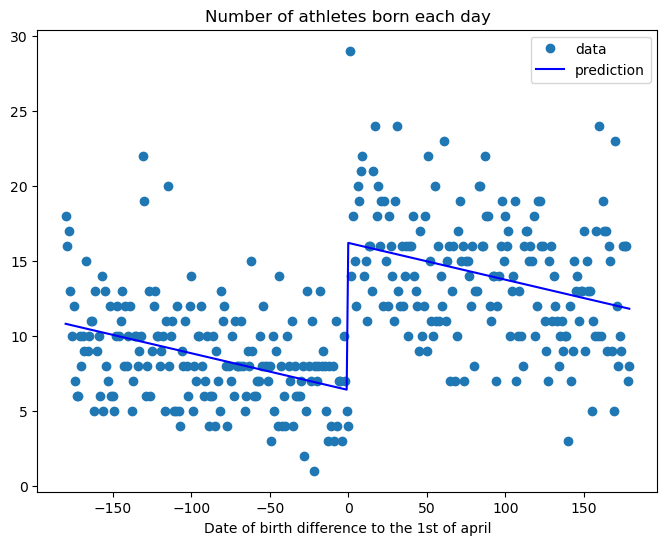

In [18]:
pred_ols = res.fittedvalues
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x, y, "o", label="data")
ax.plot(x, pred_ols, "b-", label="prediction")
plt.legend()
plt.title('Number of athletes born each day')
plt.xlabel('Date of birth difference to the 1st of april')
plt.show()

**3.7**

In the graph above, we observe that the number of athlete decrease from the 1 april to the 31 March. There is a gap between these two dates and we can see that there is twice as much athlete born in the 1 april than in the 31 march.
We can then conclude that there is an obvious causal effect between the birthdate and the chances of becoming an Wikipedia-famous athlete in japan.

A similir distribution can be observed in question 2.1, where we have plotted the number of Wikipedia-famous athletes acording to their birth month.

We can have a look at the 95% confidence interval for the slope in the summary of question 3.3, proving chances are higher to find a Wikipedia-famous japan athlete born at the start of the scholar year rather than at the end. Knowing from 2.2 that the birth distribution over months for japanese is equal for all months, chances to become a Wikipedia-famous athlete are higher if one is born in april or in may rather than in february or in march.

## Task 4 — 20 pts

You return to Mr. Ogane with your findings, which he again receives with great interest. The sharp manager, however, asks a question that ignites your curiosity: *are athletes that are born right after the school cut-off date (i.e., in April or May) simply better?**

To understand if that is the case, you come up with a plan: the number of pageviews received by a Wikipedia page is a good way to differentiate between mildly famous athletes and truly famous ones. Thus you can do a matched analysis comparing athletes born in February or March (right before the cut-off) with athletes born in April or May (right after the cut-off); you should discard all athletes that were not born in one of these four months.

To make matched athletes even more comparable, you will also only consider pairs of athletes that:
1. were born in the same year; 
2. have the same gender; and
3. have the same occupation.

Matching should be done 1-to-1; i.e., each athlete born in February/March should be matched to one and only one athlete born in April/May (there will naturally be some athletes left unmatched).

**4.1** Obtain the matched data described in the text above. Report the number of matched pairs and the number of discarded athletes. Your resulting dataframe should contain one row per athlete and an indicator variable `is_after`, which equals 1 when the athlete was born in April or May and 0 otherwise. Note that here you are doing exact matching, and not propensity score matching!

**4.2** The number of pageviews is heavy-tailed, as we have seen in Task 1. Create a new column in your matched dataframe containing the natural logarithm of the number of pageviews.

**4.3** Assuming that whether the athlete is born in the two months right before the cutoff (February and March) or the two months right after (April and May) is assigned at random, use a linear regression to estimate the effect of being born after rather than before the cutoff date in the number of pageviews athletes receive. Use the log-transformed value you calculated in **4.2** as the outcome of your model (i.e., the $y$ of the regression). Report the summary of your model.


**4.4** **Discuss:** Interpret the coefficients obtained from the linear regression.

**4.5** Interpreting the results obtained throughout this homework, create a short text (max. 250 words) where you:
- Present and explain a credible causal diagram capturing the relationship between the variables below, and justify your causal diagram given the questions answered in this homework:
    1. "Skill": an individual's innate talent towards a sport.
    2. "Relative Age": how old an individual was in comparison to his or her peers.
    3. "Success before adulthood": how successful the individual is as an athlete as a child/teenager.
    4. "Success as an adult": how successful the individual is as an athlete as an adult.
- **Discuss:** Consider two equally successful children athletes, one born on March 31 and the other on April 1 — which will likely be more successful as an adult? Your answer should be consistent with your causal diagram.

---


In [19]:
# 4.1 

# we use the 'birthdate' column (conversion to datetime done in 1.1)
# athletes born in February or March
before = (jp_athletes[(jp_athletes['birthdate'].dt.month==2) | (jp_athletes['birthdate'].dt.month==3)])
before['is_after'] = 0
# athletes born in April or May
after = (jp_athletes[(jp_athletes['birthdate'].dt.month==4) | (jp_athletes['birthdate'].dt.month==5)])
after['is_after'] = 1

athlete_pairs = pd.DataFrame(columns = before.columns)

for i in range(len(before)):
    before_athlete = before.iloc[np.random.randint(0,len(before))]
    matches=after[(after['occupation']==before_athlete['occupation']) 
                & (after['gender']==before_athlete['gender']) 
                & (after['birthyear']==before_athlete['birthyear'])]

    if len(matches)>0:
        after_athlete = matches.iloc[np.random.randint(0,len(matches))]
        athlete_pairs.loc[len(athlete_pairs)] = before_athlete
        athlete_pairs.loc[len(athlete_pairs)] = after_athlete
        after=after[after['id']!=after_athlete['id']]
    before=before[before['id']!=before_athlete['id']]

print(f"There are {int(len(athlete_pairs)/2)} matched pairs of athletes.")
print(f"{int(len(jp_athletes)-len(athlete_pairs))} athletes were discarded.")
athlete_pairs

There are 358 matched pairs of athletes.
3407 athletes were discarded.


,id,name,occupation,gender,alive,bplace_country,birthdate,birthyear,pageviews,date_diff,is_after
0,51476538,Isao Taniguchi,SOCCER PLAYER,M,True,Japan,1991-02-16,1991,1273.0,-44,0
1,25417322,Hiroyuki Furuta,SOCCER PLAYER,M,True,Japan,1991-05-23,1991,4958.0,52,1
2,27507279,Sho Kamogawa,SOCCER PLAYER,M,True,Japan,1983-02-07,1983,855.0,-53,0
3,20273520,Takuma Hidaka,SOCCER PLAYER,M,True,Japan,1983-04-08,1983,1443.0,7,1
4,55194901,Kensho Ogasawara,SOCCER PLAYER,M,True,Japan,1995-03-26,1995,533.0,-6,0
...,...,...,...,...,...,...,...,...,...,...,...
711,51420188,Koki Otani,SOCCER PLAYER,M,True,Japan,1989-04-08,1989,3759.0,7,1
712,7603841,Mitsunori Yoshida,SOCCER PLAYER,M,True,Japan,1962-03-08,1962,4554.0,-24,0
713,25865423,Tomoyasu Asaoka,SOCCER PLAYER,M,True,Japan,1962-04-06,1962,1951.0,5,1
714,52494314,Tatsuya Hasegawa,SOCCER PLAYER,M,True,Japan,1994-03-07,1994,17452.0,-25,0


In [20]:
# 4.2 
# compute the natural logarithm of each athlete's pageviews
athlete_pairs['log_pageviews'] = np.log(athlete_pairs['pageviews'].astype(float))
athlete_pairs

,id,name,occupation,gender,alive,bplace_country,birthdate,birthyear,pageviews,date_diff,is_after,log_pageviews
0,51476538,Isao Taniguchi,SOCCER PLAYER,M,True,Japan,1991-02-16,1991,1273.0,-44,0,7.149132
1,25417322,Hiroyuki Furuta,SOCCER PLAYER,M,True,Japan,1991-05-23,1991,4958.0,52,1,8.508758
2,27507279,Sho Kamogawa,SOCCER PLAYER,M,True,Japan,1983-02-07,1983,855.0,-53,0,6.751101
3,20273520,Takuma Hidaka,SOCCER PLAYER,M,True,Japan,1983-04-08,1983,1443.0,7,1,7.274480
4,55194901,Kensho Ogasawara,SOCCER PLAYER,M,True,Japan,1995-03-26,1995,533.0,-6,0,6.278521
...,...,...,...,...,...,...,...,...,...,...,...,...
711,51420188,Koki Otani,SOCCER PLAYER,M,True,Japan,1989-04-08,1989,3759.0,7,1,8.231908
712,7603841,Mitsunori Yoshida,SOCCER PLAYER,M,True,Japan,1962-03-08,1962,4554.0,-24,0,8.423761
713,25865423,Tomoyasu Asaoka,SOCCER PLAYER,M,True,Japan,1962-04-06,1962,1951.0,5,1,7.576097
714,52494314,Tatsuya Hasegawa,SOCCER PLAYER,M,True,Japan,1994-03-07,1994,17452.0,-25,0,9.767210


In [21]:
# 4.3 

# we assume the x of the regression is the binary 'is_after' variable
model = smf.ols(formula='log_pageviews ~ C(is_after)', data=athlete_pairs)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          log_pageviews   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     14.85
Date:                Fri, 02 Dec 2022   Prob (F-statistic):           0.000127
Time:                        23:37:45   Log-Likelihood:                -1210.0
No. Observations:                 716   AIC:                             2424.
Df Residuals:                     714   BIC:                             2433.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.8317      0.069  

# 4.4

The p-value for the "is_after" parameter is < 0.05  so there is a significant effect which means that a relationship exist between the number of pageviews and the month of birth. Moreover, the ratio of the 2 coefficients of the formula: *7.8317 - 0.3783\*is_after* is about 22, which means that "is_after" influences the log_pageviews by 4,8%. However, since the "is_after" coefficient is negative, the people born in february or march tend to have more views on their wikepedia page.


# 4.5


Here is causal diagram linking the skill, the relative age, the child success and the adult success of a japanese athlete.

![Causal diagram](CausalDiag.png)




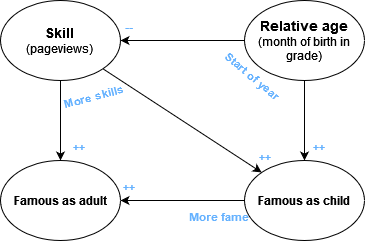

In [22]:
from IPython.display import Image, display
display(Image(filename='CausalDiag.png', embed=True))

We have seen in task 2 that the relative age to one's peers will have an impact on the Wikipedia-fame. However this impacts only the athletes during their childhood following the resons we proposed in question 2.5: a japan student born in the early scholar year will have more chance to become Wikipedia-famous.

On the other hand, we have seen in task 3 that the month of birth, has an impact on an athlete's skills (it would be more relevant to talk about pageviews here but we considered in task 4 that pageviews are a mesure of one's innate talent towards a sport). As showed in question 4.3 and 4.4, this impact is different from the previous one, as someone born in the early scholar year tend to have less pageviews and skills.

Moreover, it is trivial that a japanese athlete with more skills will have better chances of becoming famous (regardless its age).

Finally, if an athlete is famous during its childhood, chances of him being famous as an adult are higher as well. The inverse in not true, as it's not because an athlete is famous during is adulthood that he was famous during its childhood.

If we take two famous athlete children, one born in April and one in March, their success does not come from their relative age, thus, should come from their skills. However we've seen in task 3 that students born in the end of year (March of February) tend to have more pageviews and to be more successfull. Following these observation, it is likely the child athlete born in March will have more chances of being successfull as an adult.

## Task 5 — 20 pts

Your findings in Task 4 provide important information for Tokyo FC to scout for young athletes. However, Mr. Ogane points out that other countries have messier cut-off dates for school (e.g., in the U.S., it varies widely by state), and thus the results may be less applicable to other countries.

While you could investigate specific cut-off dates per country, you decide to first use your machine learning skills to get a sense of how promising your efforts might turn out to be. This is made easy as you find an extended version of the dataset you've been working on so far, which contains data about all Wikipedia biographies all around the world

**5.1**Load the dataset containing data about Wikipedia-famous individuals into memory using pandas. You should load the data directly from the compressed file. Then, print the first few lines of the dataset.


**5.2** Create two columns in this dataframe:
- `is_athlete` an indicator variable which equals 1 if the occupation of an individual is related to a sport (you are provided with a list below) and 0 otherwise.
- `dayofyear` an integer between 1 and 366 indicating on which day of the year the individual was born.

**5.3** For each country:
- Create a training set with 80% of the individuals and a test set with the remaining 20%;
- Train a random forest model (using `sklearn`, you can use the default parameters) to predict whether an individual is an athlete or not based on: 1) the day of the year they were born `dayofyear`; 2) the year they were born (e.g., 1964, year should be a numerical variable) and 3) their gender.
- report the precision of your classifier for each country.

**5.4** Estimate the percentage of `athlete` individuals per country (simply by counting in the data).

**5.5** **Discuss:** how can the results from **5.4** impact the metric (precision) used in **5.3**? What could be a better suited metric to use here?

**5.6** Repeat the procedure done in **5.3**, but now calculate the metric you proposed in **5.5**.

**5.7** **Discuss:** according to this analysis, in which other countries might you be able to use the date of birth to recruit good athletes? Justify.

In [23]:
# 5.1
wikifamous = pd.read_csv('data/all_entities.csv.gz')

# Convert the birthdate strings to Datetime objects
wikifamous['birthdate'] = pd.to_datetime(wikifamous['birthdate'], format="%Y-%m-%d").dt.to_pydatetime()
wikifamous['birthyear'] = wikifamous['birthyear'].astype(int)

# Due to inconsistencies between the year in the birthdate column and the year in the birthyear column,
# we assume the year in the birthdate column is the correct one
jp_athletes['birthyear'] = jp_athletes['birthdate'].dt.year

wikifamous.head(5)

,id,name,occupation,gender,alive,bplace_country,birthdate,birthyear,pageviews
0,4848272,Donald Trump,POLITICIAN,M,True,United States,1946-06-14,1946,10221172.0
1,13623554,Che Guevara,SOCIAL ACTIVIST,M,False,Argentina,1928-06-14,1928,3660108.0
2,1687680,Pope Francis,RELIGIOUS FIGURE,M,True,Argentina,1936-12-17,1936,3893767.0
3,21492751,Nelson Mandela,SOCIAL ACTIVIST,M,False,South Africa,1918-07-18,1918,4359499.0
4,63747,Muhammad Ali,BOXER,M,False,United States,1942-01-17,1942,3940228.0


In [24]:
athlete_categories = {
    'ATHLETE',
    'BASKETBALL PLAYER',
    'BOXER',
    'CYCLIST',
    'GYMNAST',
    'HANDBALL PLAYER',
    'HOCKEY PLAYER',
    'SKATER',
    'SKIER',
    'TENNIS PLAYER',
    'SOCCER PLAYER',
    'SWIMMER',
    'WRESTLER'
}

In [25]:
# 5.2

wikifamous['is_athlete']= 1*wikifamous['occupation'].isin(athlete_categories)        
wikifamous['dayofyear'] = wikifamous['birthdate'].dt.day_of_year
    
wikifamous

,id,name,occupation,gender,alive,bplace_country,birthdate,birthyear,pageviews,is_athlete,dayofyear
0,4848272,Donald Trump,POLITICIAN,M,True,United States,1946-06-14,1946,10221172.0,0,165
1,13623554,Che Guevara,SOCIAL ACTIVIST,M,False,Argentina,1928-06-14,1928,3660108.0,0,166
2,1687680,Pope Francis,RELIGIOUS FIGURE,M,True,Argentina,1936-12-17,1936,3893767.0,0,352
3,21492751,Nelson Mandela,SOCIAL ACTIVIST,M,False,South Africa,1918-07-18,1918,4359499.0,0,199
4,63747,Muhammad Ali,BOXER,M,False,United States,1942-01-17,1942,3940228.0,1,17
...,...,...,...,...,...,...,...,...,...,...,...
49218,56315624,Red Gerard,ATHLETE,M,True,United States,2000-06-29,2000,1630.0,1,181
49219,44634432,Abbey Weitzeil,SWIMMER,F,True,United States,1996-12-03,1996,528.0,1,338
49220,34437098,Michelle Creber,ACTOR,F,True,Canada,1999-09-07,1999,463.0,0,250
49221,36605204,Constantine Louloudis,ATHLETE,M,True,United Kingdom,1991-09-15,1991,403.0,1,258


In [26]:
# 5.3

# import
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split dataframe by country: we create a dictionary of dataframes of individuals from the dataset, one per country
countries = wikifamous['bplace_country'].unique()
wikifamous_by_country = {country : pd.DataFrame(columns=wikifamous.columns) for country in countries}
X = {country : pd.DataFrame(columns=['dayofyear', 'birthyear', 'gender']) for country in countries}
y = {country : pd.DataFrame(columns=['is_athlete']) for country in countries}

# create dataframe of model precision for each country
precisions = pd.DataFrame(columns=['country', 'precision'])
precisions['country'] = countries
precisions['precision'] = np.zeros(len(precisions)).astype(float)

for c in wikifamous_by_country.keys():
    
    # create each country's dataframe
    wikifamous_by_country[c] = wikifamous[wikifamous['bplace_country']==c]
    
    # split into X (features) and y (labels)    
    wikifamous_features = ['dayofyear', 'birthyear', 'gender']
    X[c] = pd.get_dummies(wikifamous_by_country[c][wikifamous_features])
    y[c] = wikifamous_by_country[c]['is_athlete']
    
    # split into training and test set (80-20)
    X_train, X_test, y_train, y_test = train_test_split(X[c], y[c], test_size=0.2, random_state=42, shuffle=True)
    
    # create and train classifier
    clf = RandomForestClassifier() # we use default parameters
    clf.fit(X_train, y_train)

    # do prediction on test set
    y_pred_test = clf.predict(X_test)
   
    # view the classification report, which contains precision
    report = classification_report(y_test, y_pred_test, output_dict=True)
    
    # add the precision of the classifier into the dataframe
    precisions['precision'][precisions['country']==c] = report['1']['precision'] 
    
precisions    

,country,precision
0,United States,0.330065
1,Argentina,0.776000
2,South Africa,0.842105
3,Spain,0.814978
4,Mexico,0.703704
5,United Kingdom,0.560166
6,Poland,0.775510
7,Russia,0.653595
8,Brazil,0.903654
9,France,0.740566


In [27]:
# 5.4
ath_percent = pd.DataFrame(columns=['country', 'percentage_of_athletes'])

# reuse the list of countries from 5.3
ath_percent['country'] = countries
ath_percent['percentage_of_athletes'] = np.zeros(len(ath_percent)).astype(float)

# reuse the DataFrame dictionary from 5.3
for c in wikifamous_by_country.keys():
    
    people = wikifamous_by_country[c]
    
    ath_count = len(people[people['is_athlete']==1])
    ppl_count = len(people)
    ath_percent['percentage_of_athletes'][ath_percent['country']==c] = 100*ath_count/ppl_count
    
ath_percent

,country,percentage_of_athletes
0,United States,16.030829
1,Argentina,72.838002
2,South Africa,45.041322
3,Spain,65.174986
4,Mexico,41.597796
5,United Kingdom,31.179394
6,Poland,44.740973
7,Russia,48.035714
8,Brazil,83.112583
9,France,45.802161


In [28]:
# To prepare for question 5.5, we create a dataframe that displays 
# both the precision of the classifier and the percentage of athletes from each country
compare_precision_percent = precisions.merge(ath_percent, on='country')
compare_precision_percent.sort_values(by='percentage_of_athletes', ascending=True, inplace=True)
compare_precision_percent

,country,precision,percentage_of_athletes
12,India,0.250000,5.535925
0,United States,0.330065,16.030829
28,Israel,0.400000,21.008403
30,Ireland,0.400000,29.477612
29,Canada,0.350000,30.815710
33,South Korea,0.500000,30.926217
5,United Kingdom,0.560166,31.179394
26,Turkey,0.777778,34.556575
16,China,0.725000,38.198198
21,Iran,0.869565,40.416667


**5.5**

According to the previous table, the precision of the model tends to be small when the percentage of athletes in a country is also small. In the other hand, a country with a large percentage of athletes has a high precision. 
The metric precision is defined as : #TruePositives / #PositivePredictions. 
For example, in a country with a low percentage of athlete, if we have 4 people with all the same parameters (day of birth, year of birth, gender) and only one of them is an athlete, the model will predict that for these parameters the person is not an athlete. So at the end it will have a high percentage of false negative and so a low precision.
If we want our model to be right and not miss any correct predictions we should use the F1 score which is a combination of the precision and the recall. F1 = (2\*recall\*precision)/(recall + precision)

In [29]:
# 5.6
# create dataframe of model's f1 for each country
metrics = pd.DataFrame(columns=['country', 'f1_score'])
metrics['country'] = countries
metrics['f1_score'] = np.zeros(len(metrics)).astype(float)

for c in wikifamous_by_country.keys():
    
    # split into X (features) and y (labels)
    wikifamous_features = ['dayofyear', 'birthyear', 'gender']
    X[c] = pd.get_dummies(wikifamous_by_country[c][wikifamous_features])
    y[c] = wikifamous_by_country[c]['is_athlete']
    
    # split into training and test set (80-20)
    X_train, X_test, y_train, y_test = train_test_split(X[c], y[c], test_size=0.2, random_state=42, shuffle=True)
    
    # create and train classifier
    clf = RandomForestClassifier() # we use default parameters
    clf.fit(X_train, y_train)

    # do prediction on test set
    y_pred_test = clf.predict(X_test)
    
    # view the classification report, which contains f1-measure
    report = classification_report(y_test, y_pred_test, output_dict=True)
    
    # add the f1 of the classifier into the dataframe
    metrics['f1_score'][precisions['country']==c] = report['1']['f1-score'] 
    
metrics 

,country,f1_score
0,United States,0.279267
1,Argentina,0.811715
2,South Africa,0.864865
3,Spain,0.800875
4,Mexico,0.740741
5,United Kingdom,0.527725
6,Poland,0.678571
7,Russia,0.660000
8,Brazil,0.892206
9,France,0.736342


In [30]:
test = metrics.merge(compare_precision_percent, on='country').sort_values(by='percentage_of_athletes', ascending=True)
test

,country,f1_score,precision,percentage_of_athletes
12,India,0.285714,0.250000,5.535925
0,United States,0.279267,0.330065,16.030829
28,Israel,0.375000,0.400000,21.008403
30,Ireland,0.434783,0.400000,29.477612
29,Canada,0.411215,0.350000,30.815710
33,South Korea,0.435897,0.500000,30.926217
5,United Kingdom,0.527725,0.560166,31.179394
26,Turkey,0.666667,0.777778,34.556575
16,China,0.716049,0.725000,38.198198
21,Iran,0.893617,0.869565,40.416667


**5.7**

The model predicts if a person is an athlete according to his day of birth, year of birth. So, in order to use the date of birth to recruit good athletes we should choose countries that have a high F1 score for the model. For example  Uruguay, Greece, Brazil, etc...